In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os

DOMAIN = 'bike'

db_dict = {
    'test':   'postgres://localhost:5432/babble_model_unittest',
    'spouse': 'postgres://localhost:5432/babble_model_spouse',
    'bike':   'postgres://localhost:5432/babble_model_bike',
    'cdr':    'postgres://localhost:5432/babble_model_cdr',
}

os.environ['SNORKELDB'] = db_dict[DOMAIN]

In [3]:
from snorkel import SnorkelSession
session = SnorkelSession()

In [6]:
from snorkel.contrib.babble.models import configuration

config = configuration
config['domain'] = DOMAIN
config['splits'] = [0,1]
config['parallelism'] = 1
config['majority_vote'] = False
config['verbose'] = False

In [9]:
from snorkel.models import candidate_subclass
from tutorials.babble import MTurkHelper

if DOMAIN == 'spouse':
    from tutorials.babble.spouse import SpouseModel
    Spouse = candidate_subclass('Spouse', ['person1', 'person2'])
    candidate_class = Spouse
    
    sm = SpouseModel(session, Spouse, config)
    output_csv_path= (os.environ['SNORKELHOME'] + 
                      '/tutorials/babble/data/spouse/mturk_spouse_01_out.csv')
    candidates = session.query(Spouse).all()
    
    helper = MTurkHelper(candidates, num_hits=25)
    explanations = helper.postprocess(output_csv_path, candidates=candidates, verbose=False)
elif DOMAIN == 'bike':
    from tutorials.babble.bike import BikeModel
    Biker = candidate_subclass('Biker', ['person', 'bike'])
    candidate_class = Biker
    
    sm = BikeModel(session, Biker, config)
    output_csv_path = (os.environ['SNORKELHOME'] + 
                       '/tutorials/babble/bike/data/VisualGenome_all_out.csv')
    SPLIT = 0
    candidates = session.query(candidate_class).filter(candidate_class.split == SPLIT).all()
    print("Candidates (split {}): {}".format(SPLIT, len(candidates)))
    
    helper = MTurkHelper(candidates, num_hits=40)
    explanations = helper.postprocess_visual(output_csv_path, verbose=False)
else:
    raise Exception('Invalid domain: {}'.format(DOMAIN))
user_lists = {}

Candidates (split 0): 2406
Num HITs unique: 40
Num HITs total: 120
Unanimous: 99
Majority: 33
Bad: 27


In [10]:
# anns_folder = '/dfs/scratch0/paroma/coco/annotations/'
# anns_folder = os.environ['SNORKELHOME'] + '/tutorials/babble/bike/data/'
# %time sm.parse(anns_folder)

In [11]:
# %time sm.extract()

In [12]:
# %time sm.load_gold()

In [13]:
%time sm.babble(explanations, user_lists=user_lists)

Created grammar with 441 rules
358 parses created from 244 out of 367 explanation(s)
Filtered to 92 LFs with duplicate semantics filter (266 filtered).
Filtered to 58 LFs with consistency filter (34 filtered).
Clearing existing...
Running UDF...
[========================================] 100%

Filtered to 47 LFs with uniform signatures filter (11 filtered).
Filtered to 30 LFs with duplicate signatures filter (17 filtered).
CPU times: user 19.7 s, sys: 1.56 s, total: 21.3 s
Wall time: 30.7 s


In [14]:
# sm.use_intro_lfs()

In [15]:
%time sm.label()

Clearing existing...
Running UDF...
[========================================] 100%


Labeled split 0: (2406,30) sparse (nnz = 39489)
Clearing existing...
Running UDF...
[========================================] 100%


Labeled split 1: (1037,30) sparse (nnz = 16778)
CPU times: user 32.3 s, sys: 1.93 s, total: 34.3 s
Wall time: 51 s


In [16]:
%time sm.supervise()

Inferred cardinality: 2
Saved 2406 marginals
CPU times: user 42.5 s, sys: 275 ms, total: 42.8 s
Wall time: 43.8 s


In [17]:
L_train = sm.labeler.load_matrix(sm.session, split=0)
train_marginals = sm.gen_model.marginals(L_train)

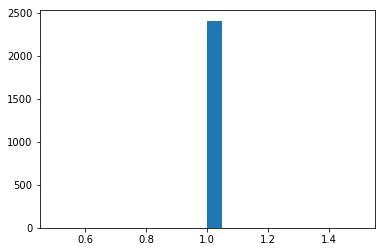

In [18]:
import matplotlib.pyplot as plt
plt.hist(train_marginals, bins=20)
plt.show()

In [19]:
sm.gen_model.learned_lf_stats()

,Accuracy,Coverage,Precision,Recall
0,0.996015,0.3011,0.995367,0.3008
1,0.002945,0.4754,0.003380,0.0016
2,0.005121,0.3710,0.003235,0.0012
3,0.003688,0.5152,0.004657,0.0024
4,0.003635,0.3301,0.004260,0.0014
5,0.999367,0.7901,0.999242,0.7912
6,0.997831,0.5071,0.997230,0.5040
7,0.998191,0.6632,0.998486,0.6596
8,0.000000,0.9979,0.000000,0.0000
9,0.003763,0.5049,0.003553,0.0018


In [20]:
L_dev = sm.labeler.apply_existing(split=1)

Clearing existing...
Running UDF...
[========================================] 100%



In [21]:
from snorkel.annotations import load_gold_labels
L_gold_dev = load_gold_labels(session, annotator_name='gold', split=1)

In [22]:
tp, fp, tn, fn = sm.gen_model.error_analysis(session, L_dev, L_gold_dev)

Scores (Un-adjusted)
Pos. class accuracy: 1.0
Neg. class accuracy: 0.0
Precision            0.203
Recall               1.0
F1                   0.337
----------------------------------------
TP: 210 | FP: 827 | TN: 0 | FN: 0



In [ ]:
# %time sm.classify()